
## Classifiez automatiquement des biens de consommation

## Compréhension du problème

----------------------------------------------------------------------------------------------------------

###  Mission

----------------------------------------------------------------------------------------------------------
- Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

- réaliser une première étude de faisabilité d'un moteur de classification, d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

- analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering, à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters.

- illustre que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

- démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie

----------------------------------------------------------------------------------------------------------

 ### Requirements : Bibliothèques utilisées dans ce notebook
 
 ----------------------------------------------------------------------------------------------------------
 
 
 ## Partie 02: Classification des images
 
  ----------------------------------------------------------------------------------------------------------

- **Import des bibliothèques**

In [43]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from sklearn import metrics
from sklearn import cluster
from sklearn import preprocessing
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score
from sklearn import manifold, decomposition
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib.image import imread
import cv2 as cv
import keras
from keras.preprocessing import image
from keras.models import Model
from PIL import Image, ImageOps ,ImageFilter
from tensorflow.python.keras.layers import Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### Chargement des données

In [2]:
# Chargement du jeu de données
df = pd.read_csv('data_net.csv')
df.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications       category_0  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   

               category_1  
0  Curtains & Accessories  
1        Baby Bath & Skin

In [3]:
# Ajout variable image_loc
# ex : data/Images/02127f52e96fb72c66bf081d25104ef8.jpg
path = "./Images/"
df['image_loc'] = [path + row for row in df['image']]

In [4]:
df_img = df.copy()
df_img= df_img[['image', 'image_loc', 'category_0']]
df_img.head(3)

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                       image_loc       category_0  
0  ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  
1  ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care  
2  ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care

In [5]:
df_image_par_cat = df_img.groupby('category_0').agg({'image' : 'count'})
df_image_par_cat

image
category_0                       
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

Home Furnishing


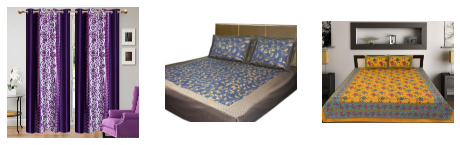

Baby Care


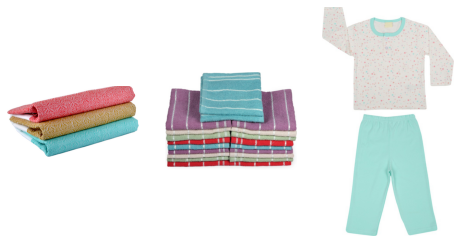

Watches


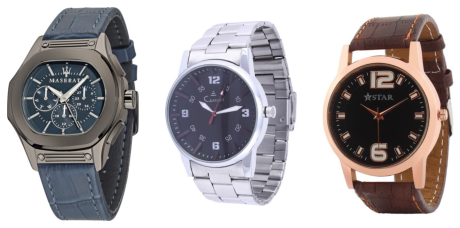

Home Decor & Festive Needs


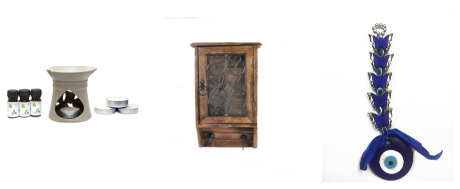

Kitchen & Dining


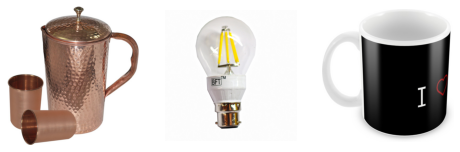

Beauty and Personal Care


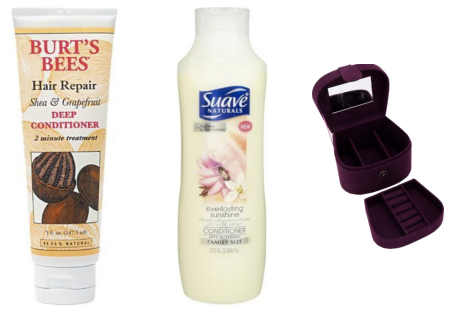

Computers


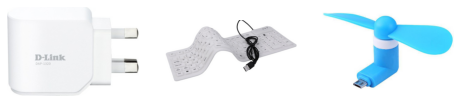

In [6]:
# affichage des images 

for j, categ in enumerate(df_img["category_0"].unique()) :
    bolded_string = "\033[1m" + categ + "\033[0m"
    print(bolded_string)
    # print("-------")
    for i in range(3):
        name_image = df_img[df_img["category_0"] == categ]["image"].iloc[i]
        plt.subplot(130 + 1 + i)
        filename = path + name_image
        img = imread(filename)
        plt.imshow(img)
        plt.axis('off')    
    plt.show()    

In [7]:
# Déscription des images 

# Largeur des images
df_img['Largeur_img'] = [Image.open(row).size[0] for row in df_img['image_loc']]
# Hauteur des images
df_img['Hauteur_img'] = [Image.open(row).size[1] for row in df_img['image_loc']]
# Taille des images
df_img['Taille_img'] = [(Image.open(row).size[0] * Image.open(row).size[1])
                      for row in df_img['image_loc']]
# Format des images
df_img['Format_img'] = [Image.open(row).mode for row in df_img['image_loc']]
df_img.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                       image_loc       category_0  \
0  ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   

   Largeur_img  Hauteur_img  Taille_img Format_img  
0         3600         3600    12960000        RGB  
1         2388         1293     3087684        RGB  
2          982          729      715878        RGB

### Pré-traitement des images

- PIL (Pyhton Imaging Library) et OpenCV (Open Compute Vision) sont des librairies qui comprennent un ensemble de méthodes permettant de charger, traiter les images (redimensionnement, filtres...). Ces librairies seront utilisées pour le pré-traitement des images.



- Le traitement sera effectué en 4 étapes :

    - redimensionnement en 224 * 224,
    - conversion de RGB (couleurs vraies) en niveaux de gris (pour Sift),
    - suppression du bruit,
    - égalisation de l'histogramme.

- **Illustration du pré-traitement sur une image**


In [8]:
def image_histopixel(image, titre):
    '''
    Afficher côte à côte l'image et l'histogramme de répartiton des pixels.
    Parameters
    ----------
    image : image à afficher, obligatoire.
    Returns
    -------
    None.
    '''
    plt.figure(figsize=(40, 10))
    plt.subplot(131)
    plt.title(titre, fontsize=30)
    plt.imshow(image, cmap='gray')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.subplot(132)
    plt.title('Histogramme de répartition des pixels', fontsize=30)
    hist, bins = np.histogram(np.array(image).flatten(), bins=256)
    plt.bar(range(len(hist[0:255])), hist[0:255])
    plt.xlabel('Niveau de gris', fontsize=30)
    plt.ylabel('Nombre de pixels', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.subplot(133)
    plt.title('Histogramme cumulé des pixels', fontsize=30)
    plt.hist(np.array(image).flatten(), bins=range(256), cumulative=True)
    plt.xlabel('Niveau de gris', fontsize=24)
    plt.ylabel('Fréquence cumulée de pixels', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

    plt.show()


In [9]:
dim = (224, 224)

### Image témoin 

images pour tester les procédures de prétraitement

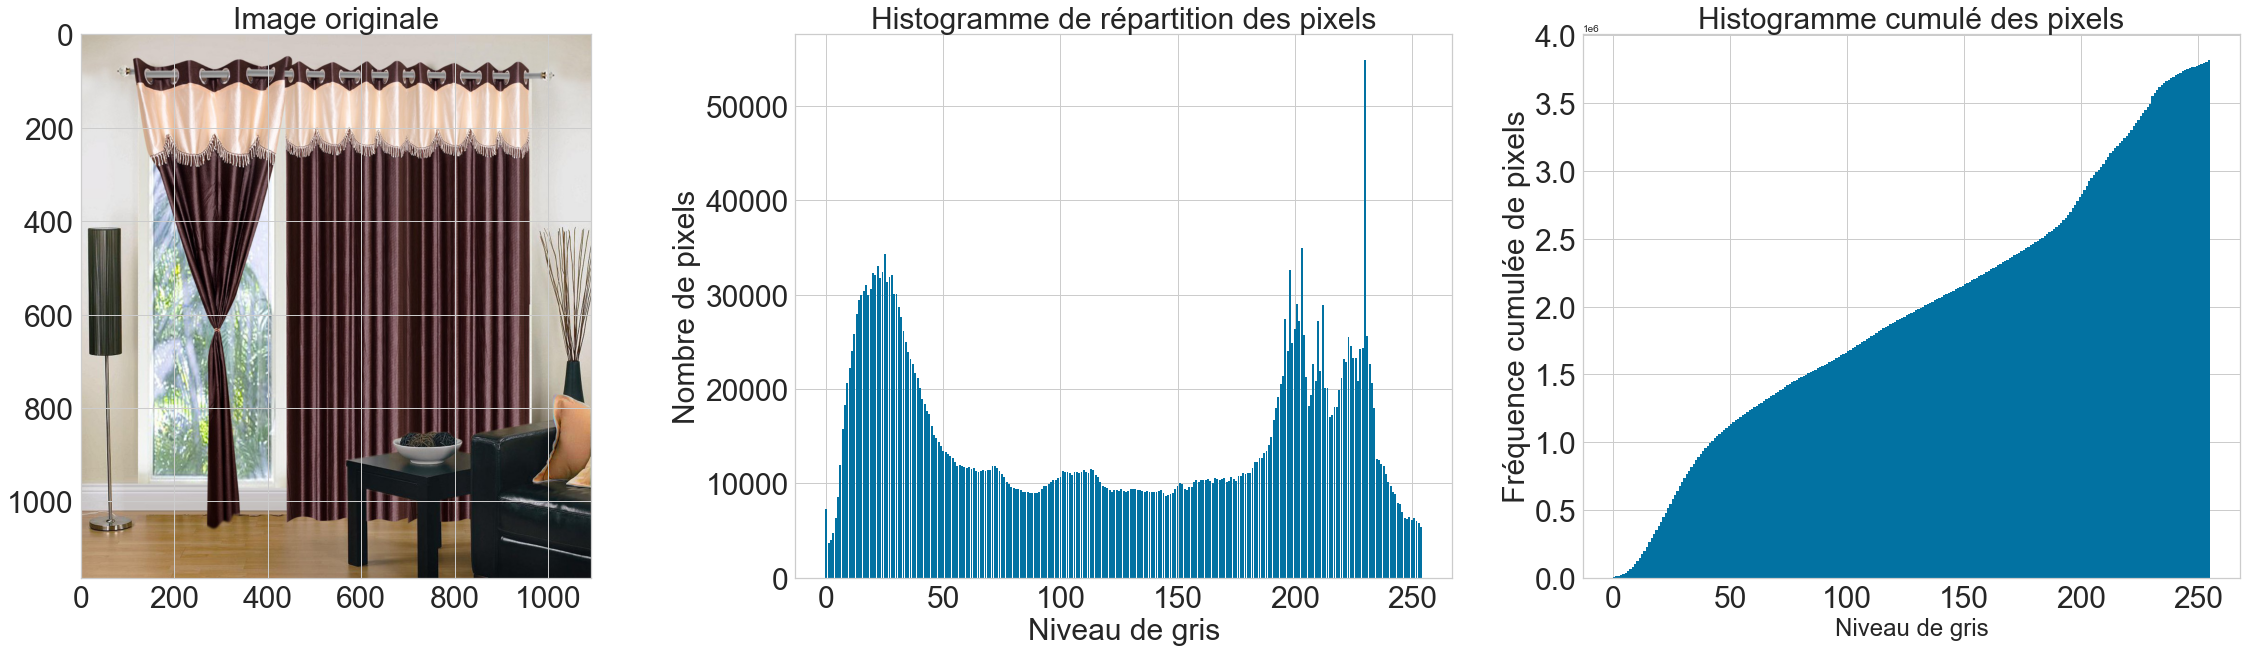

In [10]:
img_orig = Image.open('./Images/678ebb5f6057dcc51948253c1b39b0b8.jpg')
image_histopixel(img_orig, 'Image originale')

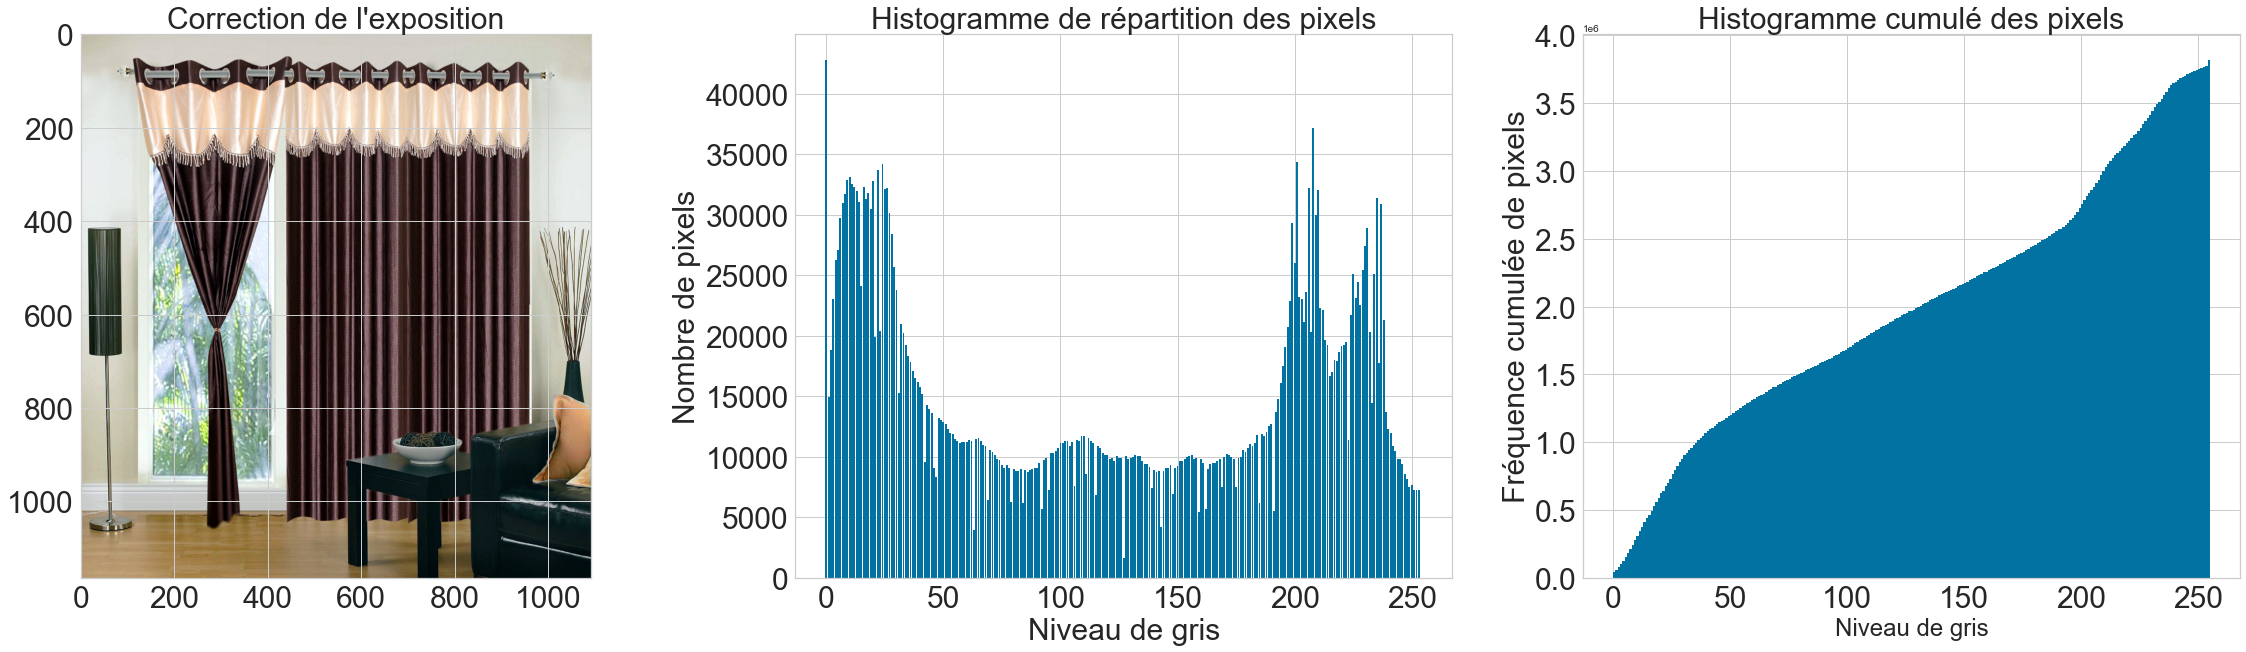

In [11]:
# Correction de l'exposition PILS
img_expo = ImageOps.autocontrast(img_orig, 1)
image_histopixel(img_expo, 'Correction de l\'exposition')

**Correction du contraste (égalisation d'histogramme)**

Le contraste caractérise la répartition de lumière dans une image : plus une image est contrastée, plus la différence de luminosité entre ses zones claires et sombres est importante. En général, une image peu contrastée est terne, tandis qu'une image trop contrastée est visuellement "agressive". Dans les deux cas, l'image manque de clarté car certains de ses détails seront peu, voire pas du tout, visibles.

[Source openclassrooms cours sur les données visuelles]

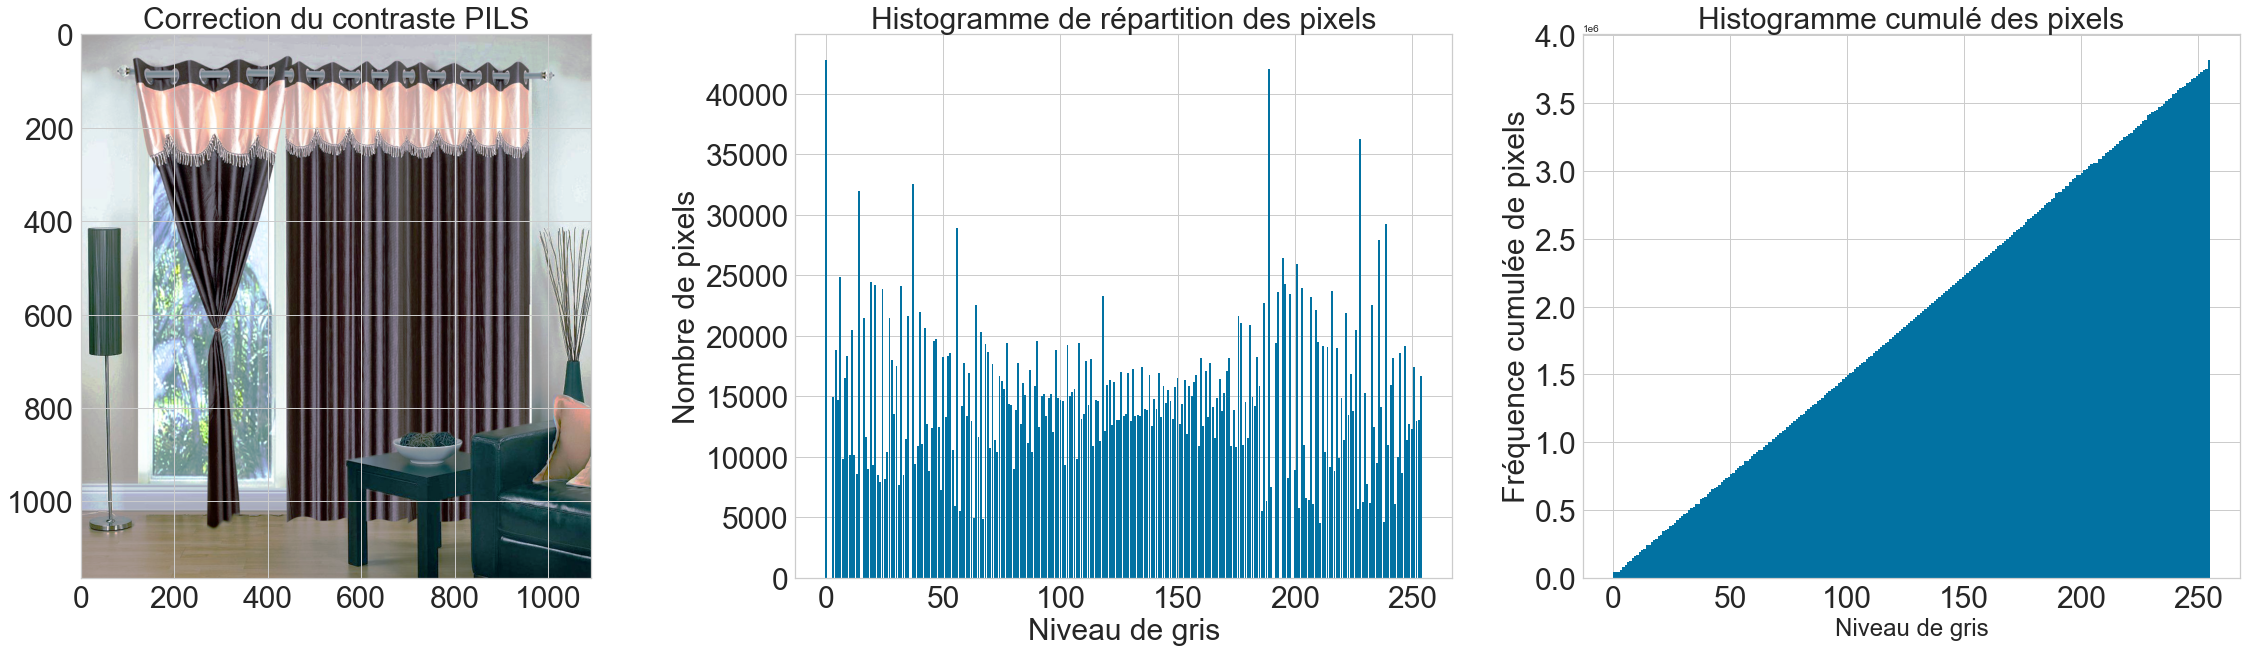

In [12]:
# Correction du contraste PILS
img_contr_pils = ImageOps.equalize(img_expo)
image_histopixel(img_contr_pils,'Correction du contraste PILS')

**Réduction du bruit (lissage)**

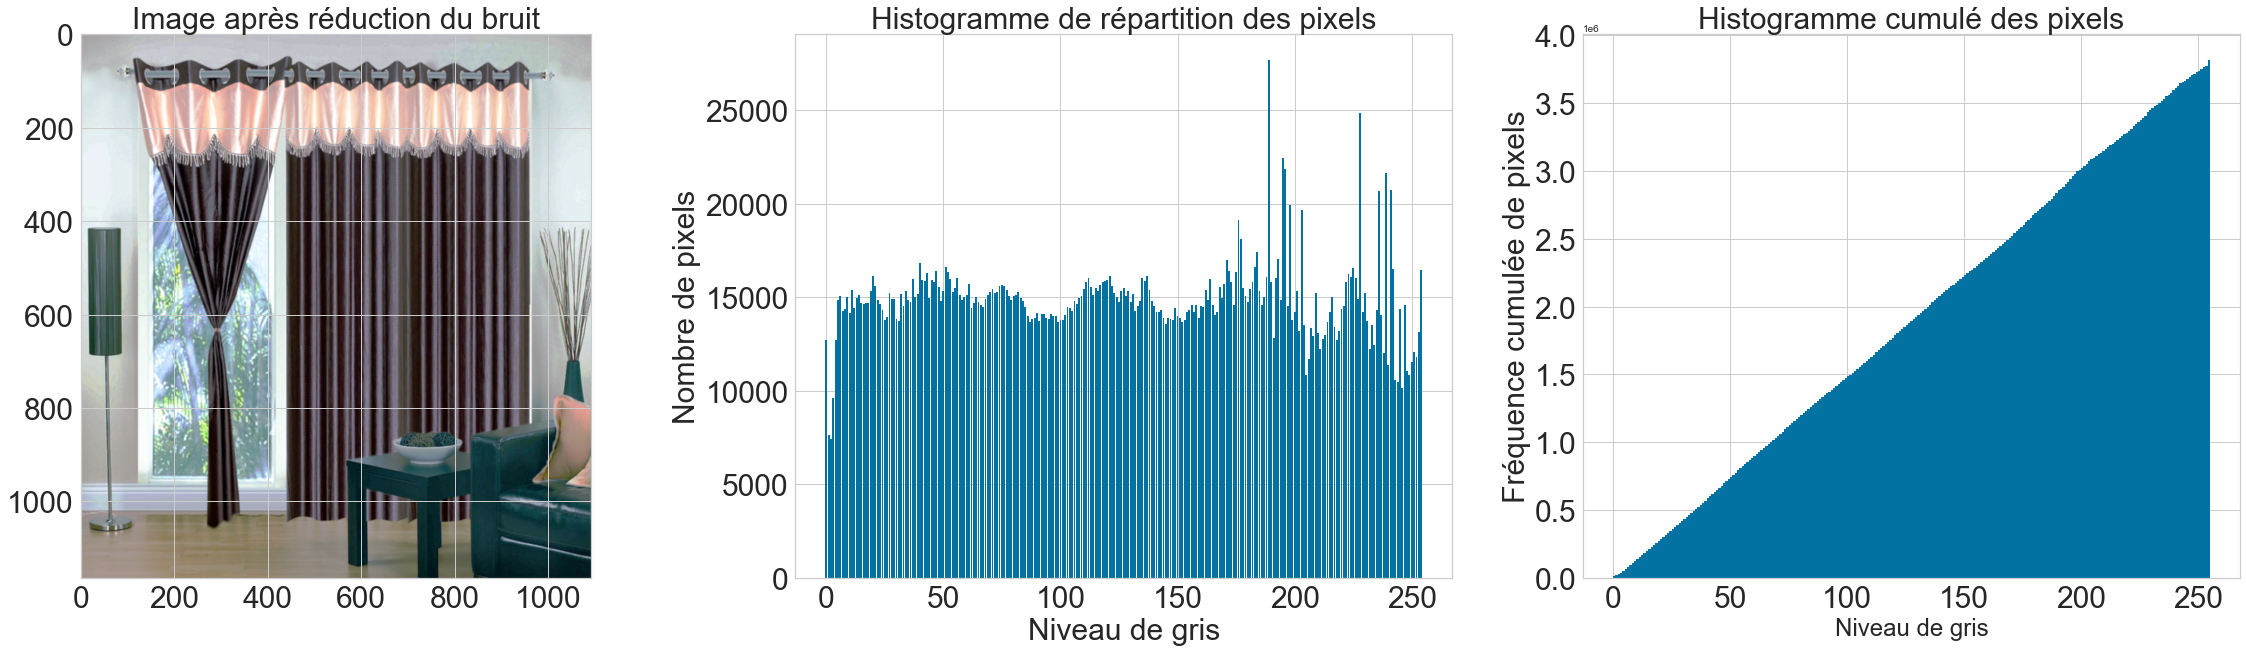

In [13]:

# Réduction du bruit (filtre)
img_filter = img_contr_pils.filter(ImageFilter.BoxBlur(1))
image_histopixel(img_filter,'Image après réduction du bruit')

**Convertir l'image en niveau de gris**

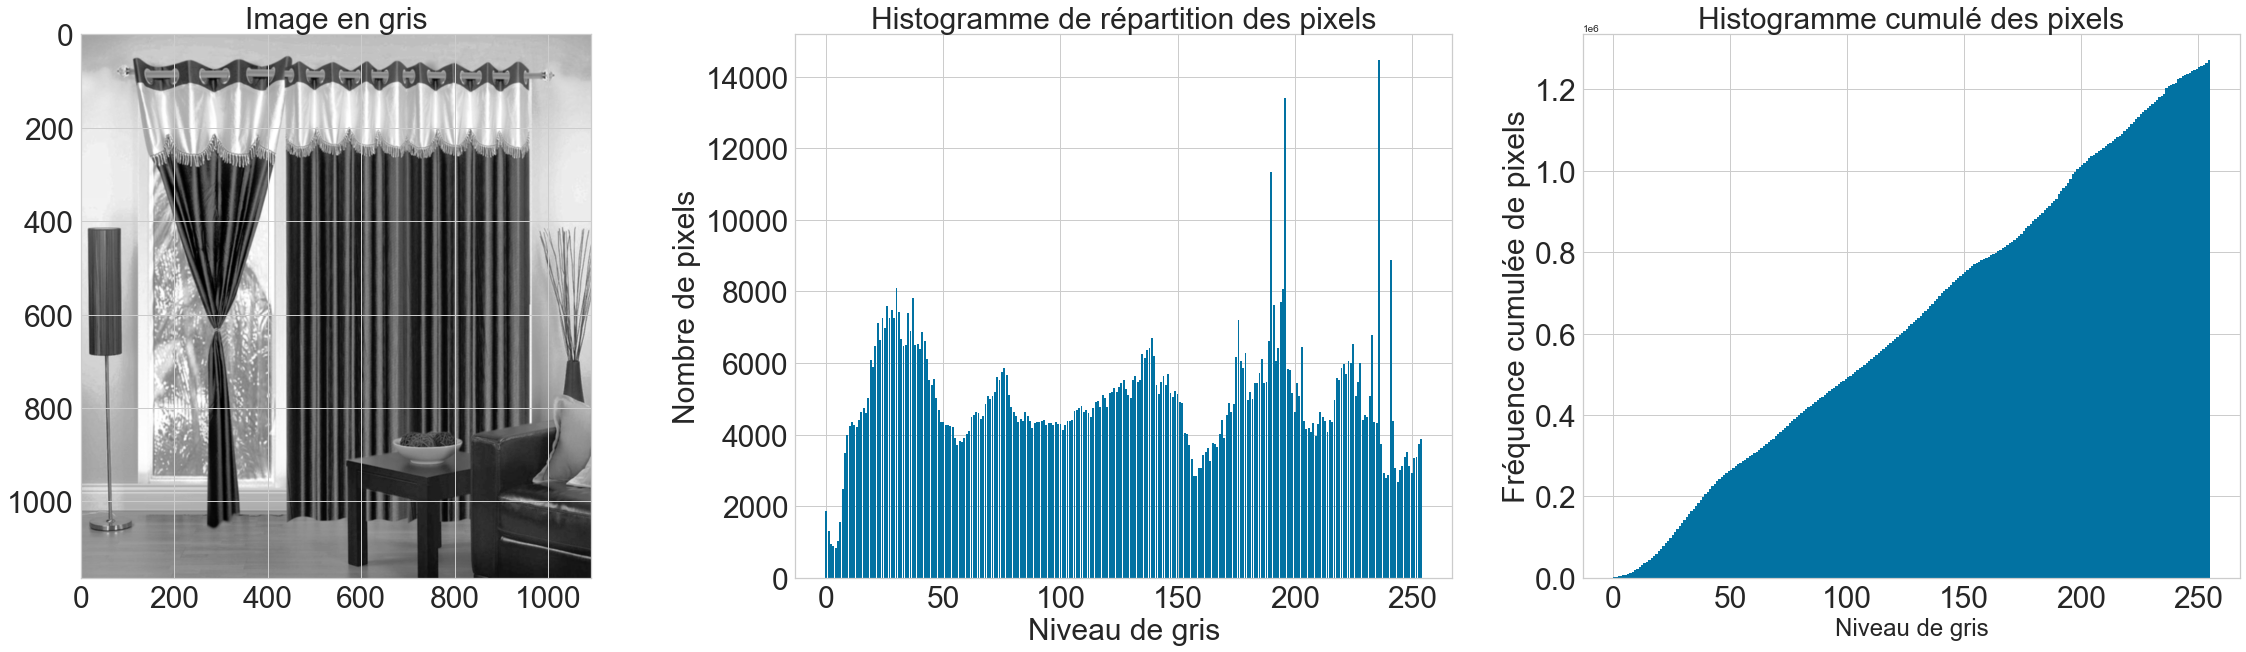

In [14]:

# Conversion de l'image en niveau de gris pour SIFT
img_gris = cv.cvtColor(np.array(img_filter), cv.COLOR_RGB2GRAY)
image_histopixel(img_gris,'Image en gris')

**Redimensionnement en 224 * 224**

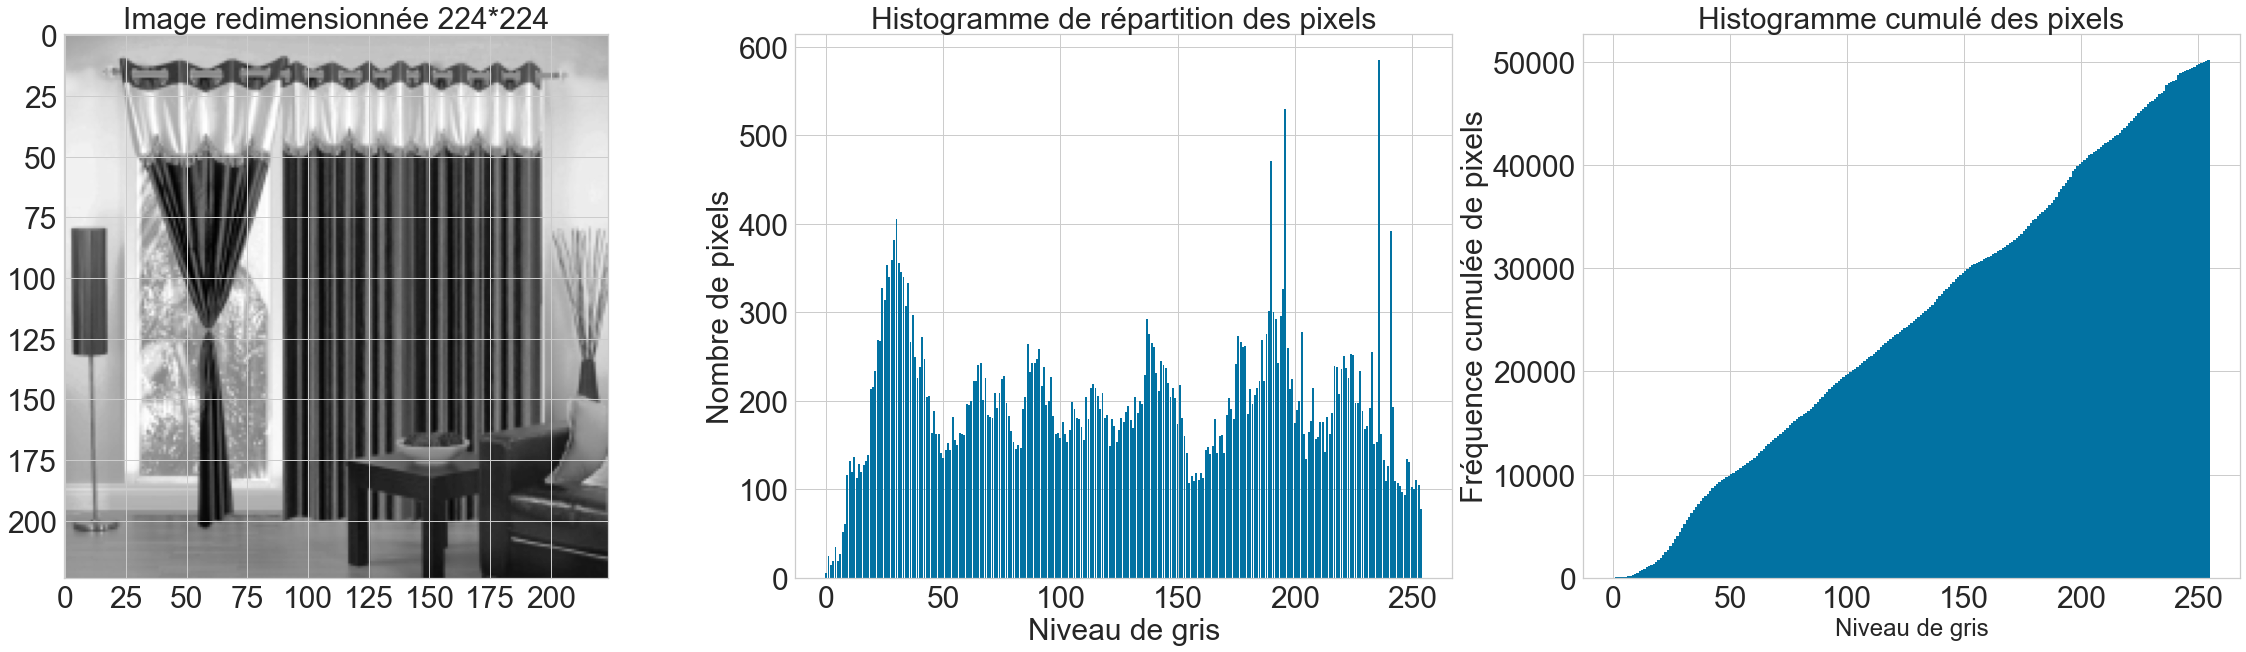

In [15]:


# Redimensionnement image contraste PILS
img_redim_pils = cv.resize(np.array(img_gris), dim,
                            interpolation=cv.INTER_AREA)
image_histopixel(img_redim_pils,'Image redimensionnée 224*224')

#### Pré-traitement de toutes les images

In [16]:
def preprocess_images(image):
    '''
    Suite aux différents tests réalisés avec les librairies PILS, OpenCv et
    Scipy, le pré-traitement suivant sera appliqué sur toutes les images :
    - Correction de l'exposition (étirement d'histogramme) avec PILS
      (autocontrast).
    - Correction du contraste (égalisation d'histogramme) avec OpenCV (CLAHE
      (Contrast Limited Adaptive Histogram Equalization).
    - Réduction du bruit avec l'algorithme Non-local Means Denoising d'OpenCV.
    - Conversion en niveau de gris de l'image (ORB, SIFT...).
    - Réduction de dimension avec OpenCV (resize et interpolation INTER_AREA).
    Parameters
    ----------
    image : image localisée dans un répertoire, obligatoire.
    Returns
    -------
    None
    '''
     # Variables locales
    dim = (224, 224)
    #dir_images_transformed = './Images/Images_process/'
    
    # Nom de l'image
    file_dir = os.path.split(image)

    # Chargement de l'image originale
    img = Image.open(image)

    # Correction de l'exposition PILS (étirement de l'histogramme)
    img = ImageOps.autocontrast(img, 1)

    # Correction du contraste (égalisation de l'histogramme)
    img = ImageOps.equalize(img)
    
    # Réduction du bruit 
    img = img.filter(ImageFilter.BoxBlur(1))
    
    # Conversion en niveau de gris de l'image
    img = cv.cvtColor(np.array(img), cv.COLOR_BGR2GRAY)    
         
    # Redimensionnement en 224 * 224
    img = cv.resize(np.array(img), dim, interpolation=cv.INTER_AREA)

    # Sauvegarde de l'image dans le répertoire data/Images_process
    cv.imwrite('./Images/Image_process/' + file_dir[1], img)

    return './Images/Image_process/' + file_dir[1]

In [17]:
# Pré-traitement de toutes les images
df_img['images_proces'] = df_img['image_loc'].apply(preprocess_images)
df_img.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                       image_loc       category_0  \
0  ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   

   Largeur_img  Hauteur_img  Taille_img Format_img  \
0         3600         3600    12960000        RGB   
1         2388         1293     3087684        RGB   
2          982          729      715878        RGB   

                                       images_proces  
0  ./Images/Image_process/55b85ea15a1536d46b7190a...  
1  ./Images/Image_process/7b72c92c2f6c40268628ec5...  
2  ./Images/Image_process/64d5d4a258243731dc7bbb1...

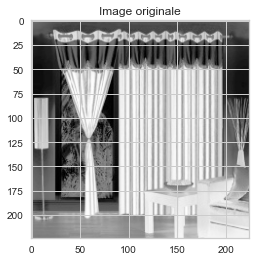

In [18]:
# Chargement de l'image précédemment traitée
img =imread('./Images/Image_process/678ebb5f6057dcc51948253c1b39b0b8.jpg')
# Visualisation de l'image
plt.figure(figsize=(4, 4))
plt.title('Image originale')
plt.imshow(img)
plt.show()

## Méthode SIFT

La scale-invariant feature transform (SIFT),
que l'on peut traduire par « transformation
de caractéristiques visuelles invariante à l'échelle »,
est un algorithme utilisé pour détecter et identifier
les éléments similaires entre différentes images
numériques (éléments de paysages, objets, personnes, etc.).
Il a été développé en 1999.


L'étape fondamentale de la méthode consiste
à calculer ce que l'on appelle les « descripteurs
SIFT » des images à étudier.
Il s'agit d'informations numériques dérivées
de l'analyse locale d'une image et qui caractérisent
le contenu visuel de cette image de la façon
la plus indépendante possible de l'échelle (« zoom »
et résolution du capteur), du cadrage, de l'angle
d'observation et de l'exposition (luminosité).


Ainsi, deux photographies d'un même objet auront
toutes les chances d'avoir des descripteurs SIFT
similaires, et ceci d'autant plus si les instants
de prise de vue et les angles de vue sont proches.




Voici le protocole que l'on va mettre en place,
pour créer notre moteur de classification des
produits à partir des images avec **SIFT** :

    1- Pour chaque image du jeu de données
         - Lire l'image
         - Réaliser le pre-processing de l'image pour augmenter la capacité de SIFT à détecter correctement les descripteurs
          Passer l'image en niveau de gris
         - Extraction des descripteurs
         
    2- Création d'une matrice contenant l'ensemble des descripteurs
    3- Clustérisation pour création des Bag of Virtual Words
    4- Création des Histogrammes
    5- Réduction de dimension PCA + T-SNE
    6- Calcul du score ARI



## Extraction des features

Nous allons utiliser l'algorithme **SIFT (Scale Invariant Feature Transform)**



La méthodoligie d'extraction de features par SIFT se fait en 3 étapes :

- Récupérer les descripteurs de chaque image par un algorithme de type SIFT
- Clusteriser l'ensemble de tous les descripteurs
- Construction de l'histogramme pour chaque image (Bag of Visual Words)

### Extraction des descripteurs sur une image

In [19]:
def gen_sift_features(gray_img):
    sift = cv.SIFT_create()
    # kp is the keypoints
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [20]:
# Transformation del'image en matrice de pixels pour OpenCV
mug = np.array(img)

# Extraction des keypoints et descripteurs SIFT
sift_keypoints, sift_descripteurs = gen_sift_features(img)

print(f"L'image contient {sift_descripteurs.shape[0]} descripteurs SIFT")
print(f'Chaque descripteur est un vecteur de longueur {sift_descripteurs.shape[1]}')


L'image contient 360 descripteurs SIFT
Chaque descripteur est un vecteur de longueur 128


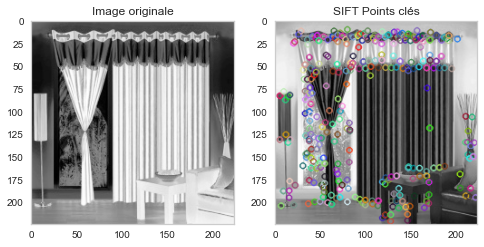

In [21]:
# Visualisation des points d'intérêt
sift_img_keypoints = cv.drawKeypoints(img, sift_keypoints, None)

plt.figure(figsize=(8, 4))
plt.grid(False)

# Image originale
plt.subplot(1, 2, 1)
plt.grid(False)
plt.title('Image originale')
plt.imshow(img)

# Image avec les points clés
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(sift_img_keypoints)
plt.title('SIFT Points clés')

plt.show()

- **Extraction des descripteurs SIFT sur l'ensemble des images**


Nous détectons les features, extrayons les descripteurs de chaque image du dataset et construisons un dictionnaire visuel.

In [22]:
def load_image_in_dict(repertoire):
    # Chargement des images pré-traitées dans un dictionnaire d'images
    images = {}
    for filename in os.listdir(repertoire):
        path = repertoire + "/" + filename
        img = cv.imread(path, 0)
        images[filename] = img
    return images

In [23]:
# Chargement des images pré-traitées dans le dictionnaire images
images = load_image_in_dict('./Images/Image_process/')
print(f'{len(images)} images chargées')

1050 images chargées


### Clustering des descripteurs

In [24]:
# Création des labels à partir du nom de catégorie produit
le = preprocessing.LabelEncoder()
df_img["label"] = le.fit_transform(df_img["category_0"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


- **Construction de l'histogramme pour chaque image (Bag of Visual Words)**

Enfin, pour chaque image, on fait un histogramme de fréquence à partir des vocabulaires (les centres des clusters obtenus à l'étape précédente) et de la fréquence des vocabulaires dans l'image. Ces histogrammes sont nos sacs de mots visuels (BOVW).

In [25]:
list_photos=df_img['images_proces']

In [28]:
# identification of key points and associated descriptors

sift_keypoints = []
temps1=time.time()
sift = cv.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv.imread(list_photos[image_num],0) # convert in gray
    res = cv.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (340099, 128)
temps de traitement SIFT descriptor :            38.26 secondes


C:\Users\karim\AppData\Local\Temp\ipykernel_20212\2195671164.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


### Création des clusters de descripteurs


Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables



Grâce à l'algorithme **MiniBatchKMeans** (une variante de l'algorithme KMeans optimisé pour réduire le temps de calcul),
nous allons clusteriser notre matrice de descripteurs calculée précedement.

Les descripteurs dont les caractéristiques seront proches seront naturellement regroupés dans des clusters identiques.





In [29]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)


Nombre de clusters estimés :  583
Création de 583 clusters de descripteurs ...


MiniBatchKMeans(init_size=1749, n_clusters=583, random_state=0)

### Création des features des images


Pour chaque image :
- prédiction des numéros de cluster de chaque descripteur
- création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image


Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [30]:
# Création d'histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Création de matrice d'histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            68.46 secondes


### Réduction de dimension 

- **ACP**

In [31]:


print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_img= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", pca_results_img.shape)

Dimensions dataset avant réduction PCA :  (1050, 583)
Dimensions dataset après réduction PCA :  (1050, 478)


- **Tsne**

In [32]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_img = tsne.fit_transform(pca_results_img)

df_tsne_img = pd.DataFrame(tsne_results_img[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_img["class"] = df_img["category_0"]
print(df_tsne_img.shape)

(1050, 3)


### Visualisation

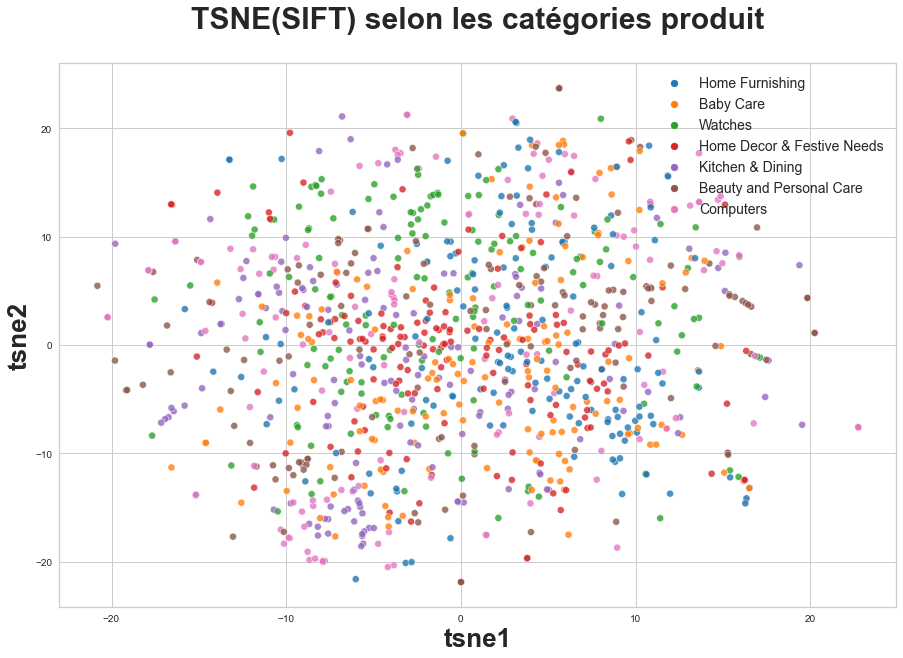

In [33]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_img, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE(SIFT) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [34]:
#Création de clusters à partir du T-SNE 
X = df_tsne_img[["tsne1","tsne2"]]

cls = KMeans(n_clusters=7, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_img["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.34788623


In [35]:
# Création des labels à partir du nom de catégory produit
df_img["label"] = le.fit_transform(df_img["category_0"])

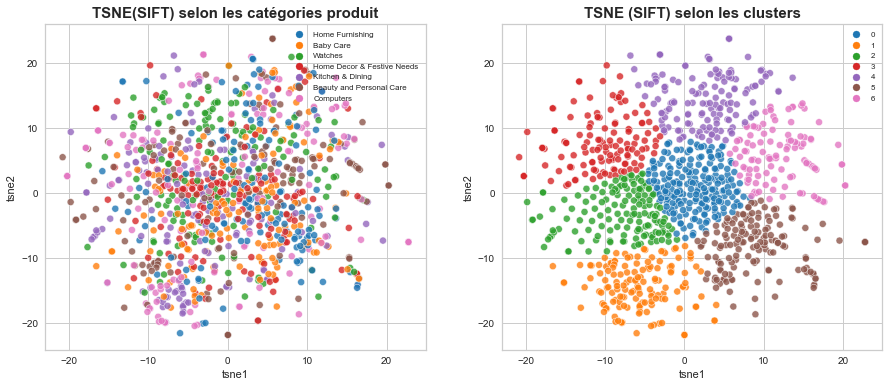

---------------------------
ARI :  0.02756702232775254
---------------------------


In [36]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_img, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE(SIFT) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 



ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_img,
    legend="brief")

plt.title('TSNE (SIFT) selon les clusters', fontsize =15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


print("---------------------------")
labels = df_img["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("---------------------------")


### Qualité de la catégorisation

**répartition des vraies catégories par cluster**

In [37]:

# Fonction pour afficher la répartition des vraies catégories par cluster

def plot_clust_vs_cat(ser_clust, ser_cat, data, figsize=(8,4),
                                  palette='tab10', ylim=(0,250),
                                  bboxtoanchor=None):
    
    # pivot = data.drop(columns=['description','image'])
    pivot = pd.DataFrame()
    pivot['label']=ser_clust
    pivot['category']=ser_cat
    pivot['count']=1
    pivot = pivot.groupby(by=['label','category']).count().unstack().fillna(0)
    pivot.columns=pivot.columns.droplevel()
    
    colors = sns.color_palette(palette, ser_clust.shape[0]).as_hex()
    pivot.plot.bar(width=0.8,stacked=True,legend=True,figsize=figsize,
                   color=colors, ec='k')

    row_data=data.shape[0]

    if ser_clust.nunique() > 15:
        font = 8 
    else : 
        font = 12

    for index, value in enumerate(ser_clust.value_counts().sort_index(ascending=True)):
        percentage = np.around(value/row_data*100,1)   
        plt.text(index-0.25, value+2, str(percentage)+' %',fontsize=font)

    plt.gca().set(ylim=ylim)
    plt.xticks(rotation=0) 

    plt.xlabel('Clusters',fontsize=14)
    plt.ylabel('Nombre de produits', fontsize=14)
    plt.title('Répartition des vraies catégories par cluster',
              fontweight='bold', fontsize=18)

    if bboxtoanchor is not None:
        plt.legend(bbox_to_anchor=bboxtoanchor)
        
    plt.show()    
    
    return pivot

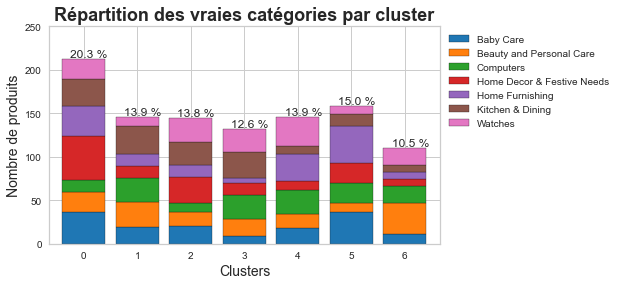

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0                36                        24         13   
1                19                        29         28   
2                20                        16         11   
3                 9                        19         28   
4                18                        16         28   
5                37                        10         23   
6                11                        36         19   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                 51               35                30   
1                                 14               13                33   
2                                 30               14                26   
3                                 14                6                30   
4                                 10               31                 9   
5                                 23               43                13   
6                                  8                8                 9   

category  Watches  
label              
0              24  
1              10  
2              28  
3              26  
4              34  
5               9  
6              19

In [38]:
plot_clust_vs_cat( df_tsne_img["cluster"],
                               df_tsne_img["class"],
                               df_tsne_img,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

### la matrice de confusion

In [39]:
# Affiche la matrice de confusion

def confusion_matrix(y_true, y_pred, title):
    """ xxx
    Args:
        y_true list(str):
        y_pred list(int):
        title (str): 
    Returns:
        -
    """
    # Create a DataFrame with labels and varieties as columns: df
    df = pd.DataFrame({'Labels': y_true, 'Clusters': y_pred})

    # Create crosstab: ct
    ct = pd.crosstab(df['Labels'], df['Clusters'])

    # plot the heatmap for correlation matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    sns.heatmap(ct.T, 
                 square=True, 
                 annot=True, 
                 annot_kws={"size": 17},
                 fmt='.2f',
                 cmap='Blues',
                 cbar=False,
                 ax=ax)

    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)
    ax.set_ylabel("clusters", fontsize=15)
    ax.set_xlabel("labels", fontsize=15)

    plt.show()

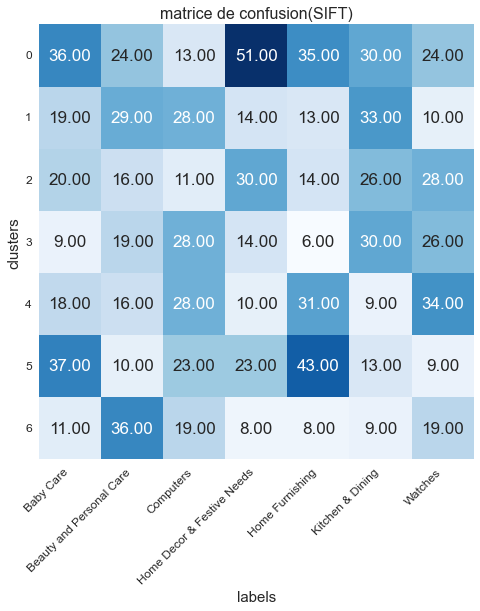

In [40]:
confusion_matrix(df_tsne_img["class"], df_tsne_img["cluster"], 'matrice de confusion(SIFT)')

 # Méthode Transfert Learning avec VGG16

Nous allons dans cette partie utiliser Keras, une bibliothèque de Deep Learning.


Nous utiliserons une version du réseau de neurones convolutif VGG-Net nommé **VGG16**.

 => Keras nous fourni une version pré-entraînée de VGG16

- VGG-16 est une version du réseau de neurones convolutif VGG-Net.
- VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.
- Il prend en entrée une image en couleurs de taille 224 × 224 px et la classifie dans une des 1000 classes. Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes.

- le Transfer Learning consiste à utiliser le modèle VGG16 pré-entraîné sur ImageNet (ImageNet est un projet de recherche visant à développer une grande base de données d'images avec des annotations, c'est-à-dire des images et leurs descriptions).

**3 étapes à suivre**

- ÉTAPE 1 - Chargement des images, extraction des features (Prétraiter chaque image selon l'entrée acceptée par le modèle d'apprentissage par transfert et convertir chaque image en vecteur respectif en utilisant les poids du modèle d'apprentissage par transfert. Ensuite, aplatissez et stockez tous les poids des images dans une liste.)



- ÉTAPE 2 - Réduction de dimension 



- ÉTAPE 3 - Clustering 

# Création du modèle d'étude avec VGG16

- **Chargement des images, extraction des features**

In [47]:
# Utilisation de VGG16 pré-entraîné sur ImageNet avec les images d'origine

# Liste
vgg16_all_features = []

# Instanciation du modèle
model_vgg16 = VGG16()

# Remove the output layer
model_vgg16= Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[-2].output)

# Résumé de l'architecture du modèle
model_vgg16.summary()

for rep_image in df_img['image_loc']:

    # Charger l'image et la redimensionner à la taille
    # requise de 224×224 pixels.
    
    img = load_img(rep_image, target_size=(224, 224))
    
    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler
    # avec dans Keras
    
    img = img_to_array(img)
    
    # Redimensionnement
    
    img = np.expand_dims(img, axis=0)
    
    # Préparer de nouvelles entrées pour le réseau.
    
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance
    # de l'image à chacun des 1000 types d'objets connus.
    
    vgg16_feature = model_vgg16.predict(img)
    
    # Ajouter la feature prédite en nparray à la liste
    
    vgg16_all_features.append(np.array(vgg16_feature).flatten())

vgg16_all_features = np.array(vgg16_all_features)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

1/1 [==============================] - 1s 852ms/step


1/1 [==============================] - 1s 830ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 747ms/step


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 1s 943ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 814ms/step


In [48]:
# Dataframe de sauvegarde des BOVW VGG16
# Association des features à chaque image
df_img['vgg16_bovw'] = [vgg16_all_features[i] for i in range(df_img.shape[0])]
# Dataframe de travail
df_vgg16_bovw = df_img[['image', 'image_loc', 'category_0', 'vgg16_bovw']]
# Constituer le dataframe de vecteurs de BOVW VGG16
df_vgg16_vectors = pd.DataFrame.from_records(vgg16_all_features)

### Réduction de dimension 


 
 
**PCA**


La réduction PCA tout en gardant 99% de variance expliquée

In [49]:
print("Dimensions dataset avant réduction PCA : ", df_vgg16_vectors.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_vgg16 = pca.fit_transform(df_vgg16_vectors)
print("Dimensions dataset après réduction PCA : ", pca_results_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


**TSNE**


Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [50]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_vgg16 = tsne.fit_transform(pca_results_vgg16)

df_tsne_vgg16 = pd.DataFrame(tsne_results_vgg16[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_vgg16["class"] =df_img["category_0"]
print(df_tsne_vgg16.shape)


(1050, 3)


### Visualisation


Affichage T-SNE selon les catégories d'images

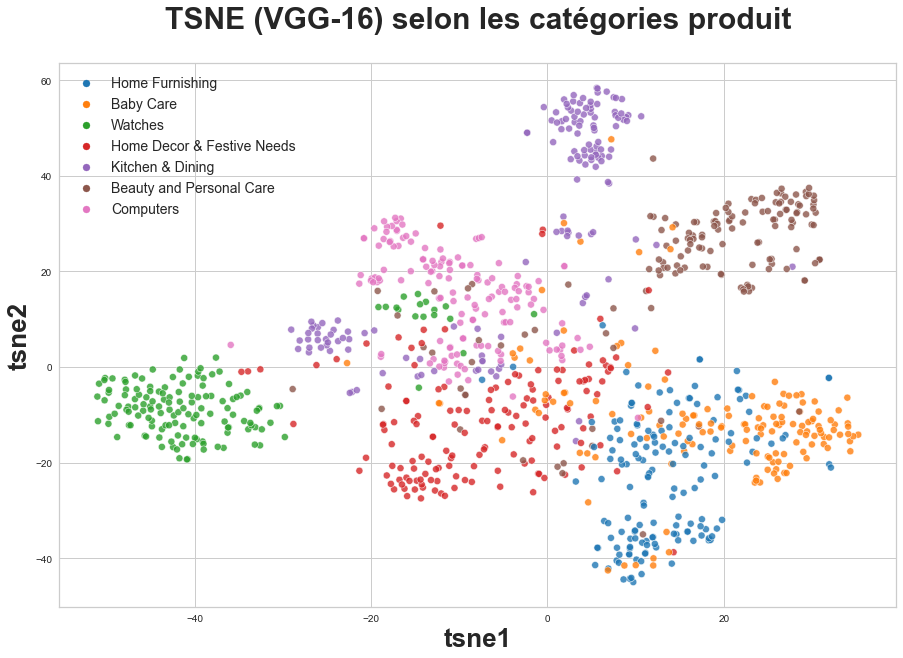

In [51]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg16, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (VGG-16) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


### Clustering

In [52]:
#Création de clusters à partir du T-SNE 
X = df_tsne_vgg16[["tsne1","tsne2"]]

cls = KMeans(n_clusters=7, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_vgg16["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.49248093


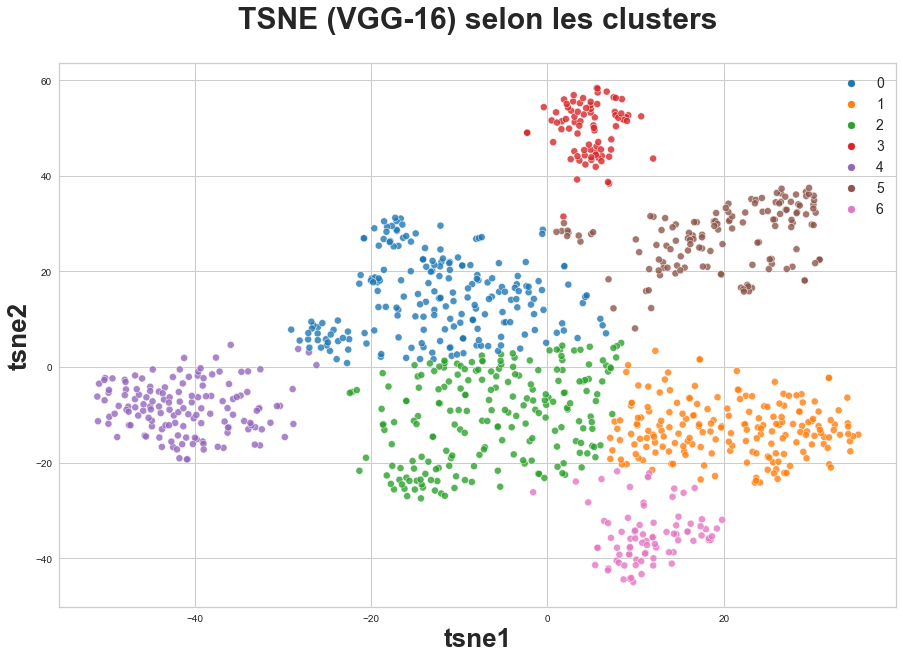

ARI :  0.5026610346398769


In [53]:
#Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_vgg16,
    legend="brief")

plt.title('TSNE (VGG-16) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_img["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

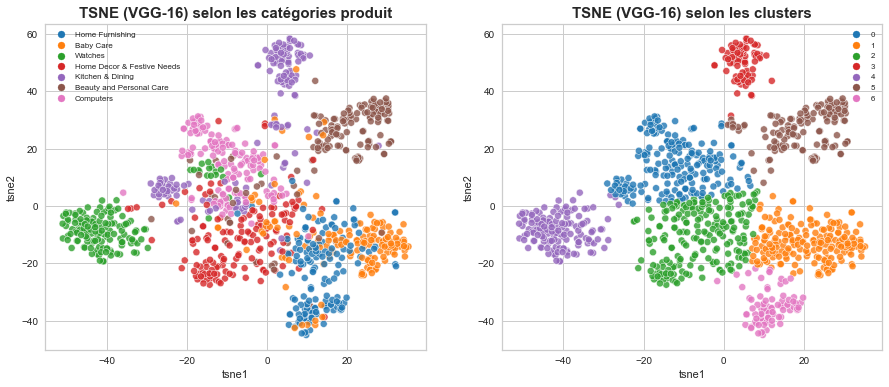

---------------------------
ARI :  0.5026610346398769
---------------------------


In [54]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg16, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (VGG-16) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 



ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_vgg16,
    legend="brief")

plt.title('TSNE (VGG-16) selon les clusters', fontsize = 15 , fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


print("---------------------------")
labels = df_img["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("---------------------------")


### Qualité de la catégorisation

**répartition des vraies catégories par cluster**

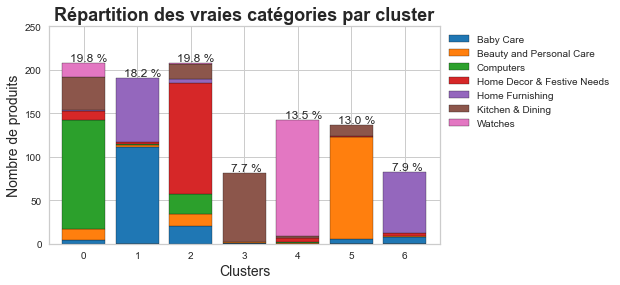

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               4.0                      13.0      125.0   
1             111.0                       3.0        1.0   
2              21.0                      13.0       23.0   
3               1.0                       1.0        0.0   
4               0.0                       1.0        1.0   
5               5.0                     118.0        0.0   
6               8.0                       1.0        0.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               11.0              1.0              38.0   
1                                2.0             74.0               0.0   
2                              128.0              4.0              18.0   
3                                0.0              0.0              79.0   
4                                5.0              0.0               2.0   
5                                1.0              0.0              13.0   
6                                3.0             71.0               0.0   

category  Watches  
label              
0            16.0  
1             0.0  
2             1.0  
3             0.0  
4           133.0  
5             0.0  
6             0.0

In [55]:
plot_clust_vs_cat( df_tsne_vgg16["cluster"],
                               df_tsne_vgg16["class"],
                              df_tsne_vgg16,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

### la matrice de confusion

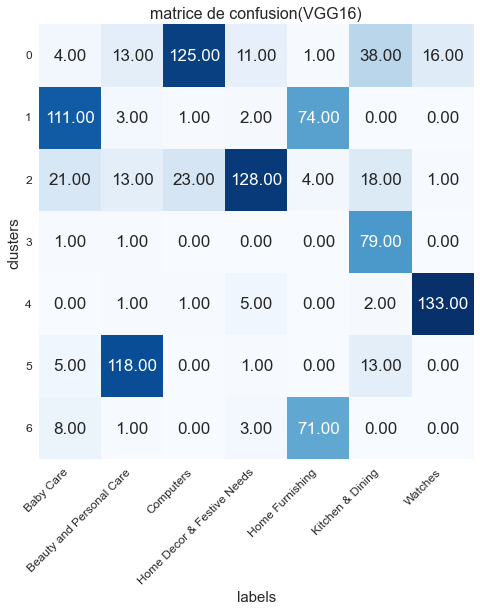

In [56]:
confusion_matrix(df_tsne_vgg16["class"], df_tsne_vgg16["cluster"], 'matrice de confusion(VGG16)')

## Conclusion 

Le VGG-16 a donné de meilleurs résultats que le SIFT


Selon les résultats du clustering, la faisabilité du moteur de classification est possible et satisfaisante avec les données textuelles, moins avec les données visuelles